In [ ]:
# default_exp data_man
%reload_ext autoreload
%autoreload 2
from nbdev.showdoc import *

# Data management
> Create, from FT1 and FT2, a compact data set with photon and livetime info.

### Overview

Fermi-LAT weekly data files are extracted from the [GSFC FTP server ](https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly), 
with subfolders for the photon data, `photon` and spacecraft data, `spacecraft`. It is [described here](http://fermi.gsfc.nasa.gov/ssc/data/access/http://fermi.gsfc.nasa.gov/ssc/data/access/)

The class `FermiData` downloads these to temporary files and constructs a dict for each week with
contents

* photons: a table, one entry per selected photon with columns, converted with `get_ft1_data`
  * run number (uint32, stored as a category by pandas)
  * time since the run start, in 2 $\mu$s intervals  (uint32)
  * energy and event type (uint8)
  * position as HEALPix index with nside, nest from Config, currently 1024, True (uint32) 
  
* sc_data: a table, one entry per 30-s interval, with columns, all float32, converted with `get_ft2_info`
  * start/stop time 
  * S/C direction 
  * zenith direction
* gti_times: an array of interleaved start/stop intervals
* file_date: modification date for the FT1 file at GSFC.

These dict objects are saved in a folder specfied by `Config().datapath`. Its contents can be 
checked with `check_data`, and udated using `update_data`.  Finally, the contents of a week can be visually 
inspected with `plot_week`.

#### Run numbers and timing

The run number is an integer correspnding to the MET at the start of the run. For a week, with 15 orbits/day, we 
expect ~105 runs. We save a table of the run numbers per week, and use a uint8 index in the photon table.

A run is typically an orbit or less, at most 6 ks. Integerizing the offset from the run start, or the run number, using 32 bits, one has 5e5 intervals/s, so we choose 2$\mu$s. Thus we generate the time for each event from three sources: the 2$\mu$s time offset for the run, the index of the run number into the  runs table, and the runs table itself.


In [ ]:
# export
import os, sys
import dateutil, datetime
from astropy.io import fits
from ftplib import FTP_TLS as FTP

import healpy
from pathlib import Path
import numpy as np
import pickle

from wtlike.config import Config, Timer, UTC, MJD

In [ ]:
# export
def get_ft1_data( config, ft1_file):

        """
        Read in a photon data (FT1) file, bin in energy and position to convert to a compact table

        - `ft1_file` -- A weekly file from GSFC

        Depends on config items
        - `theta_cut, z_cut` -- selection criteria
        - `ebins, etypes` -- define band index
        - `nside, nest` -- define HEALPix binning

        Returns a dict with keys

        - `tstart`, the start MET time from the FT1 header

        - `photons`: a dict with keys and entries for each selected photon
           - `band` (uint8):    energy band index*2 + 0,1 for Front/Back
           - `nest_index`  if nest else `ring_index` (uint32): HEALPIx index for the nside
           - `run_ref` (uint8) reference to the run number, in the array `runs`
           - `trun` (unit32): time since the run id in 2 $\mu s$ units

        - `gti_times` -- GTI times as an interleaved start, stop array.
        - `runs` -- a list of the run numbers, each a MET time. Expect 109 per week

        For the selected events above 100 MeV, this represents 10 bytes per photon, vs. 27 in the FT1 data
        """

        delta_t = config.offset_size
        ebins = config.energy_edges
        etypes = config.etypes
        nside = config.nside
        nest = config.nest
        z_cut =config.z_max
        theta_cut = np.degrees(np.arccos(config.cos_theta_max))
        verbose = config.verbose

        with  fits.open(ft1_file) as ft1:
            tstart = ft1[1].header['TSTART']

            ## GTI - setup raveled array function to make cut
            gti_data= ft1['GTI'].data
            # extract arrays for values of interest
            data =ft1['EVENTS'].data

        a,b = sorted(gti_data.START), sorted(gti_data.STOP)

        gti_times = np.ravel(np.column_stack((a,b)))
        if np.any(np.diff(gti_times)<0):
            raise Exception(f'Non-monatonic GTI found in file {ft1_file}')

        # def apply_gti(time):
        #     x = np.digitize(time, gti_times)
        #     return np.bitwise_and(x,1).astype(bool)

        # apply  selections

        sel =  ((data['ENERGY'] > ebins[0]) &
                (data['ZENITH_ANGLE'] < z_cut) &
                (data['THETA'] < theta_cut))

        dsel = data[sel]

        # get the columns for output
        glon, glat, energy, et, z, theta, time, ec =\
             [dsel[x] for x in 'L B ENERGY EVENT_TYPE ZENITH_ANGLE THETA TIME EVENT_CLASS'.split()]

        # generate event_type masks
        et_mask={}
        for ie in etypes:
            et_mask[ie]= et[:,-1-ie]


        if verbose>2:
            total = sum(b)-sum(a)
            fraction = total/(b[-1]-a[0])

            print(  f'FT1: {ft1_file.name}, GTI range {a[0]:.1f}-{b[-1]:.1f}:  {len(data):,} photons'\
                    f'\n\tSelection E > {ebins[0]:.0f} MeV. theta<{theta_cut:.1f} and z<{z_cut} remove:'\
                    f' {100.- 100*len(dsel)/float(len(data)):.2f}%'
                 )


                # event class -- turn into single int for later mask
        #         bits = np.array([1<<n for n in range(20)])
        #         def to_bin(x):
        #             return np.sum(bits[x[:20]])
        #         ec = [to_bin(row[20]) for row in ec

        # pixelate direction
        hpindex = healpy.ang2pix(nside, glon, glat, nest=nest, lonlat=True).astype(np.uint32)
        hpname = 'nest_index' if nest else 'ring_index'

        # digitize energy and create band index incluing (front/back)
        band_index = (2*(np.digitize(energy, ebins, )-1) + et_mask[1]).astype(np.uint8)

        #
        run_id = dsel['RUN_ID'].astype(np.uint32)
        
        # save this for for run reference
        runlist = np.unique(run_id)

        # a dict with all photon info, which requires runlist
        runs = np.unique(run_id)
        photons = {'band' : band_index,
                  hpname : hpindex,
                  'run_ref': np.searchsorted(runs, run_id).astype(np.uint8),
                  'trun'  : ((time-run_id)/delta_t).astype(np.uint32),
                 }
                  
        if verbose>1:
            print(f'FT1 data from file {ft1_file.name}: tstart={tstart:.0f} (UTC {UTC(MJD(tstart))[:-6]})' 
                  f' selected {len(dsel):,}/{len(data):,} photons, in {len(runlist)} runs.')

        return  dict(tstart=tstart, #df,
                     photons=photons, 
                     gti_times=gti_times, 
                     runlist=runlist)

In [ ]:
show_doc(get_ft1_data, title_level=2)

<h2 id="get_ft1_data" class="doc_header"><code>get_ft1_data</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h2>

> <code>get_ft1_data</code>(**`config`**, **`ft1_file`**)

Read in a photon data (FT1) file, bin in energy and position to convert to a compact table

- `ft1_file` -- A weekly file from GSFC

Depends on config items
- `theta_cut, z_cut` -- selection criteria
- `ebins, etypes` -- define band index
- `nside, nest` -- define HEALPix binning

Returns a dict with keys

- `tstart`, the start MET time from the FT1 header

- `photons`: a dict with keys and entries for each selected photon
   - `band` (uint8):    energy band index*2 + 0,1 for Front/Back
   - `nest_index`  if nest else `ring_index` (uint32): HEALPIx index for the nside
   - `run_ref` (uint8) reference to the run number, in the array `runs`
   - `trun` (unit32): time since the run id in 2 $\mu s$ units

- `gti_times` -- GTI times as an interleaved start, stop array.
- `runs` -- a list of the run numbers, each a MET time. Expect 109 per week

For the selected events above 100 MeV, this represents 10 bytes per photon, vs. 27 in the FT1 data

In [ ]:
# export
def get_ft2_info(config, filename,
                 gti=lambda t: True):
    """Process a FT2 file, with S/C history data, and return a summary dict

    Parameters:

    * config -- verbose, cos_theta_max, z_max
    * filename -- spacecraft (FT2) file
    * gti -- GTI object that checkes for allowed intervals, in MJD units

    Returns: A dict with fields consistent with GTI if specified

    * start, stop -- interval in MJD units
    * livetime -- sec
    * ra_scz, dec_scz --spaceraft direction
    * ra_zenith, dec_zenith -- local zenith
    """
    # combine the files into a dict  with following fields besides START and STOP (lower case for column)
    fields    = ['LIVETIME','RA_SCZ','DEC_SCZ', 'RA_ZENITH','DEC_ZENITH']
    with fits.open(filename) as hdu:
        scdata = hdu['SC_DATA'].data
        tstart, tstop = [float(hdu[0].header[field]) for field in  ('TSTART','TSTOP') ]

    if config.verbose>1:
        print(f'FT2: {filename.name}, MET range {tstart:.1f}-{tstop:.1f},', end='')# {"not" if gti is None else ""} applying GTI')

    # get times to check against MJD limits and GTI
    start, stop = [MJD(np.array(scdata.START, float)),
                   MJD(np.array(scdata.STOP, float))]

    # apply GTI to bin center (avoid edge effects?)
    in_gti = gti(0.5*(start+stop))
    if config.verbose>1:
        s = sum(in_gti)
        print(f' {len(start)} entries, {s} ({100*s/len(start):.1f}%) in GTI')

    t = [('start', start[in_gti]), ('stop',stop[in_gti])]+\
        [(field.lower(), np.array(scdata[field][in_gti],np.float32)) for field in fields ]


    sc_data = dict(t)

    return sc_data

In [ ]:
show_doc(get_ft2_info, title_level=2)

<h2 id="get_ft2_info" class="doc_header"><code>get_ft2_info</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h2>

> <code>get_ft2_info</code>(**`config`**, **`filename`**, **`gti`**=*`<lambda>`*)

Process a FT2 file, with S/C history data, and return a summary dict

Parameters:

* config -- verbose, cos_theta_max, z_max
* filename -- spacecraft (FT2) file
* gti -- GTI object that checkes for allowed intervals, in MJD units

Returns: A dict with fields consistent with GTI if specified

* start, stop -- interval in MJD units
* livetime -- sec
* ra_scz, dec_scz --spaceraft direction
* ra_zenith, dec_zenith -- local zenith

In [ ]:
# exporti
def filepaths(week):
    """Returns: A tuple with two elements for the week number, each with two triplets with:
        ftp folder, ftp filename, local simple filename
    """
    urls = []
    for ftype, alias in  [('spacecraft','ft2'), ('photon','ft1')]:
         urls.append((
             f'{ftype}',
             f'lat_{ftype}_weekly_w{week:03d}_p{"305" if ftype=="photon" else "310" }_v001.fits',
             f'week{week:03d}_{alias}.fits',
            ))
    return urls

In [ ]:
# exporti
class GSFCweekly(dict):

    ftp_site = 'heasarc.gsfc.nasa.gov'
    ftp_path = 'fermi/data/lat/weekly'
    local_path  = '/tmp/from_gsfc'

    def __init__(self, config=None):
        """ Obtain lists of the weekly FT1 and FT2 files at GSFC, Set up as a dict, with
        keys= week numbers, values=mofification date strings
        """
        self.config = config or Config()
        self.wtlike_data_file_path = Path(self.config.datapath/'data_files')
        assert self.wtlike_data_file_path.is_dir(), 'Data path invalid'
        os.makedirs(self.local_path, exist_ok=True)
        try:
            with FTP(self.ftp_site) as ftp:
                ftp.login()
                ftp.prot_p()
                ftp.cwd(self.ftp_path+'/photon') # or spacecraft
                # aet modification time and type for all files in folder

                parse_week = lambda fn:  int(fn.split('_')[3][1:])
                flist = ftp.mlsd(facts=['modify', 'type'])
                self.fileinfo = sorted([(parse_week(name), fact['modify']) for name,fact in flist
                                 if fact['type']=='file' and name.startswith('lat') ])
        except Exception as msg:
            print(f'FTP login to or download from {self.ftp_site} failed:\n\t--> {msg}',file=sys.stderr)
            self.valid=False
            return
        self.update(self.fileinfo)
        self.valid=True
    
    def download(self, week):
        """ Download the given week's files to the local folder
        
        week -- the mission week number, starting at 9. If negative, get recent one
        
        return the ft1, ft2 local filenames
        """
        
        if week<0:
            week = list(self.keys())[week]
        assert week in self, f'week {week} not found at FTP site'
        files = []
        with FTP(self.ftp_site) as ftp:
            ftp.login()
            ftp.prot_p()
            for ftp_folder, ftp_filename, local_filename in filepaths(week):
                ftp.cwd('/'+self.ftp_path+'/'+ftp_folder)
                if self.config.verbose>0:
                    print(f'GSFCweekly: {ftp_folder}/{ftp_filename} --> {local_filename}', flush=True)
                with open(f'{self.local_path}/{local_filename}', 'wb') as  localfile:
                    ftp.retrbinary('RETR ' + ftp_filename, localfile.write) 
                files.append(local_filename)
        return files
    
    def week_number(self, met):
        return (met-233711940)//(7*24*3600)
    
    def load_week(self, week):
        """Load a pickled week summary """
        filename = self.wtlike_data_file_path/f'week_{week:03d}.pkl'
        assert filename.exists(), f'File {filename} does not exist'
        with open(filename, 'rb') as imp:
            ret = pickle.load(imp)
        return ret

    def check_week(self, week):
        """Returns True if the local week needs updating"""
        data = self.load_week(week)
        if 'file_date' not in data:
            return True
        return data['file_date'] == self[week]
    


In [ ]:
# collapse-hide
print( 'Exercise access from GSFC and FT1 data handling')
gd = GSFCweekly(Config(verbose=3))
ft2, ft1 = gd.download(-2)
v = get_ft1_data(gd.config, Path(gd.local_path)/ft1);

print('Contents of the output dict\n'
      ' key      value type')
for (k,x) in v.items():
    print(f'  {k:10} {x.__class__.__name__}')

Exercise access from GSFC and FT1 data handling
GSFCweekly: spacecraft/lat_spacecraft_weekly_w725_p310_v001.fits --> week725_ft2.fits
GSFCweekly: photon/lat_photon_weekly_w725_p305_v001.fits --> week725_ft1.fits
FT1: week725_ft1.fits, GTI range 672193803.7-672797715.1:  2,149,244 photons
	Selection E > 100 MeV. theta<66.4 and z<100 remove: 84.22%
FT1 data from file week725_ft1.fits: tstart=672193803 (UTC 2022-04-21) selected 339,183/2,149,244 photons, in 106 runs.
Contents of the output dict
 key      value type
  tstart     float
  photons    dict
  gti_times  ndarray
  runlist    ndarray


In [ ]:
week_number = lambda met: (met-233711940)//(7*24*3600)
week_number(671587140), week_number(671587130)

(724, 723)

In [ ]:
# export
class FermiData(GSFCweekly):
    """ Manage the full data set in weekly chunks
    * Checking the current set of files at GSFC
    * downloading a week at a time to a local tmp
    * Converting to condensed format and saving to pickled dicts in wtlike_data
    """

    @property
    def local_filedate(self):
        """ the datetime object representing the last file date in local storage"""
        from dateutil.parser import parse
        weekly_folder = self.config.datapath/'data_files'
        ff = sorted(list(weekly_folder.glob('*.pkl')))
        if len(ff)==0:
            print(f'No .pkl files found in {weekly_folder}', file=sys.stderr)
            return None

        wk = list(map(lambda f: int(os.path.splitext(f)[0][-3:]), ff))
        lastweek = pickle.load(open(ff[-1],'rb'))
        return dateutil.parser.parse(lastweek['file_date'])

    @property
    def gsfc_filedate(self):
        return dateutil.parser.parse(list(self.values())[-1])

    def __str__(self):
        return f'FermiData: {len(self.fileinfo)} week files at GSFC, from {self.fileinfo[0]} to {self.fileinfo[-1]}'

    def in_temp(self):
        """return list of GSFC copied files in the local_path folder"""
        names = [f.name for f in Path(self.local_path).glob('*')]
        return names

    def __call__(self, week, test=False, tries_left=2):
        """ Download and convert the given week:
        * download FT1 and FT2 from GSFC to scratch space
        * convert each
        * save pickled dict summary
        * remove files

        """
        assert week in self, f'week {week} not found at FTP site'
        ff = filepaths(week)
        ft1_file = Path(self.local_path)/ff[1][2]
        ft2_file = Path(self.local_path)/ff[0][2]

        if self.config.verbose>1:
            print(f'FermiData: converting week {week}')

        while tries_left>0:
            try:
                if not (ft1_file.exists() and ft2_file.exists()):
                    self.download(week)
                # convert photon data to compact form, as a dice
                week_summary = get_ft1_data(self.config, ft1_file)
                break
            except Exception as e:
                print(f'*** ERROR *** Failed to convert {ft1_file}: {e} download it again)', 
                      file=sys.stderr)
                tries_left -=1
                if tries_left==0:
                    print(f'Failed to convert week file {ft1_file}: quitting', file=sys.stderr)
                    return None
                else:
                    os.unlink(ft1_file)

        def apply_gti(time): # note MJD
            x = np.digitize(time, MJD(week_summary['gti_times']))
            return np.bitwise_and(x,1).astype(bool)
        sc_data = get_ft2_info(self.config, ft2_file, apply_gti)

        # finished with copies of FT1 and FT2 files: delete them
        for file in (ft1_file,ft2_file):
            os.unlink(file)

        # add file date and space craft summary
        week_summary['file_date'] = self[week]
        week_summary['sc_data'] = sc_data
        filename = self.wtlike_data_file_path/f'week_{week:03d}.pkl'
        if filename.exists() and config.verbose>0:
            print(f'FermiData: replacing existing {filename}',flush=True)
        if not test:
            with open(filename, 'wb') as out:
                pickle.dump(week_summary, out)

        if self.config.verbose>0:
            print(f'FermiData: Saved to {filename}', flush=True)

    def download_and_convert(self, week_range,  processes=None):
        """Download FT1 and FT2 files from GSFC and create summary files for the weeks
        
        * week_range: a (first, last+1) tumple, or a iterable 
        
        """
        from multiprocessing import Pool

        processes = processes or config.pool_size
        txt = f', using {processes} processes ' if processes>1 else ''

        if config.verbose>0:
            print(f'\tDownloading {len(week_range)} week files{txt}\n', end='', flush=True)

        if processes>1:
            with Pool(processes=processes) as pool:
                pool.map(self, week_range)
        else:
            map(self,  week_range)
    


    def needs_update(self, threshold=0):
        """ Compare files on disk with the GSFC list and compile list that need to be downloaded

        Check the file date of the last one on disk and include it if it is:
        
        * short and there is one or more GSFC weeks following it,
        * the most recent week and is short by more than *threshold* days
        """
        gg =self.wtlike_data_file_path.glob('*.pkl')

        file_weeks= map(lambda n: int(n.name[5:8]), gg)
        ondisk = np.array(list(file_weeks))

        missing =  list(set(self.keys()).difference(set(ondisk)))

        last = ondisk[-1]
        if last not in missing and not self.check_week( last):
            delta = (self.gsfc_filedate -self.local_filedate).seconds/24/3600
            if delta> threshold:
                missing.append(last)
        return missing

    def process(self, days=1):
        """ Download and process all weeks missing or needing an update, if within `days`
        from the present

        Return status: True if  anything changed
        """
        # will use multprocessing if len(todo)>1 and pool_size>1
        todo = self.needs_update(days)
        if len(todo)==0: return False
        if self.config.pool_size >1 and len(todo)>1:
            print('multitasking not applied yet', file=sys.stderr)
            pass
        list(map(self, todo))
        return True
    
    def get_run_times(self, week):
        r = self.load_week(week)
        pdict = r['photons']
        if 'run_id' in pdict:
            runs = np.unique(pdict['run_id'])
        elif 'run_ref' in pdict:
            runs = r['runlist'][pdict['run_ref']]
        else:
            assert False
        return MJD(runs)

In [ ]:
show_doc(FermiData)
show_doc(FermiData.download)
show_doc(FermiData.needs_update)

<h2 id="FermiData" class="doc_header"><code>class</code> <code>FermiData</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>FermiData</code>(**`config`**=*`None`*) :: [`GSFCweekly`](/wtlikedata_man.html#GSFCweekly)

Manage the full data set in weekly chunks
* Checking the current set of files at GSFC
* downloading a week at a time to a local tmp
* Converting to condensed format and saving to pickled dicts in wtlike_data

<h4 id="GSFCweekly.download" class="doc_header"><code>GSFCweekly.download</code><a href="__main__.py#L34" class="source_link" style="float:right">[source]</a></h4>

> <code>GSFCweekly.download</code>(**`week`**)

Download the given week's files to the local folder

week -- the mission week number, starting at 9. If negative, get recent one

return the ft1, ft2 local filenames

<h4 id="FermiData.needs_update" class="doc_header"><code>FermiData.needs_update</code><a href="__main__.py#L112" class="source_link" style="float:right">[source]</a></h4>

> <code>FermiData.needs_update</code>(**`threshold`**=*`0`*)

Compare files on disk with the GSFC list and compile list that need to be downloaded

Check the file date of the last one on disk and include it if it is:

* short and there is one or more GSFC weeks following it,
* the most recent week and is short by more than *threshold* days

In [ ]:
self = FermiData()
if self.valid:
    print(self, '\n  need(s) update: ', self.needs_update())

FermiData: 717 week files at GSFC, from (9, '20220228224421') to (726, '20220503220258') 
  need(s) update:  [726]


In [ ]:
self.needs_update()

[726]

In [ ]:
show_doc(FermiData.__call__)
show_doc(FermiData.process)
show_doc(FermiData.check_week)

<h4 id="FermiData.__call__" class="doc_header"><code>FermiData.__call__</code><a href="__main__.py#L35" class="source_link" style="float:right">[source]</a></h4>

> <code>FermiData.__call__</code>(**`week`**, **`test`**=*`False`*, **`tries_left`**=*`2`*)

Download and convert the given week:
* download FT1 and FT2 from GSFC to scratch space
* convert each
* save pickled dict summary
* remove files

<h4 id="FermiData.process" class="doc_header"><code>FermiData.process</code><a href="__main__.py#L134" class="source_link" style="float:right">[source]</a></h4>

> <code>FermiData.process</code>(**`days`**=*`1`*)

Download and process all weeks missing or needing an update, if within `days`
from the present

Return status: True if  anything changed

<h4 id="GSFCweekly.check_week" class="doc_header"><code>GSFCweekly.check_week</code><a href="__main__.py#L69" class="source_link" style="float:right">[source]</a></h4>

> <code>GSFCweekly.check_week</code>(**`week`**)

Returns True if the local week needs updating

In [ ]:
fd = FermiData()
if fd.valid:
    check =fd.needs_update(0.5)
    print(fd, f'\n\tweek(s) needing update: {check}' )

FermiData: 717 week files at GSFC, from (9, '20220228224421') to (726, '20220503220258') 
	week(s) needing update: []


In [ ]:
# export
def check_data(config=None):
    """
    Return: sorted list of files, last week number, number of days in last week"""
    if config is None: config=Config()
    if config.valid:
        weekly_folder = config.datapath/'data_files'
        ff = sorted(list(weekly_folder.glob('*.pkl')))
        if len(ff)==0:
            print(f'No .pkl files found in {weekly_folder}', file=sys.stderr)
            return
        getwk = lambda f: int(os.path.splitext(f)[0][-3:])
        wk = [getwk(f) for f in ff] #list(map(lambda f: int(os.path.splitext(f)[0][-3:]), ff))
        lastweek = pickle.load(open(ff[-1],'rb'))
        
        file_date = lastweek['file_date']
        gti = lastweek['gti_times'];
        days = (gti[-1]-gti[0])/(24*3600)
        if config.verbose>0:
            print(f'Weekly folder "{weekly_folder}" contains {len(wk)} weeks.'\
                  f'\n\t Last week, # {wk[-1]}, has {days:.3f} days, ends at UTC {UTC(MJD(gti[-1]))}, filedate {file_date}' )
        return ff, wk[-1], days
    else:
        print(f'Config not valid, {config.errors}', file=sys.stderr)
        return None
    
def update_data(update_threshold=1, config=None):
    """Bring all of the local week data summaries up to date, downloading the missing ones from GSFC.
    If the last one is the current week, check to see if needs updating, by comparing file date, in days,
    from the last update with the current one at GSFC.
    """
    ff = FermiData(config)
    return ff.process(update_threshold)

In [ ]:
show_doc(check_data,  title_level=2)

<h2 id="check_data" class="doc_header"><code>check_data</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h2>

> <code>check_data</code>(**`config`**=*`None`*)

Return: sorted list of files, last week number, number of days in last week

In [ ]:
check_data();
update_data();

Weekly folder "/home/burnett/fermi/wtlike-data/data_files" contains 717 weeks.
	 Last week, # 726, has 5.252 days, ends at UTC 2022-05-03 06:24, filedate 20220503120345


In [ ]:
# collapse-hide
# code to count the total number of photons in the local dataset
tz=[]; num=[]; elapsed=[]; week=[]
if Config().valid:
    count = 0
    for f in check_data()[0]:
        week.append(int(f.name[-7:-4]))
        with open(f,'rb') as imp:
            t = pickle.load(imp);
            g= t['photons']
            n = len(g)
            num.append(n)
            count += n
            h = t['sc_data']
            if type(h)==dict:
                elapsed.append( h['stop'][-1]-h['start'][0] )
            else:
                elapsed.append( h['stop'].values[-1]-h['start'][0] )
            tz.append(t['tstart'])
        print( '.',end='')
    print(f'\nTotal number of photons: {count:,}')

    tz = np.array(tz); 
    print('Run check, expect week gaps of 1 or 2', 
          np.unique(np.diff(np.array([int(week_number(x)) for x in tz])),return_counts=True))

Weekly folder "/home/burnett/fermi/wtlike-data/data_files" contains 717 weeks.
	 Last week, # 726, has 5.252 days, ends at UTC 2022-05-03 06:24, filedate 20220503120345
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Total number of photons: 240,715,501
Run check, expect week gaps of 1 or 2 (array([1, 2]), array([715,   1]))


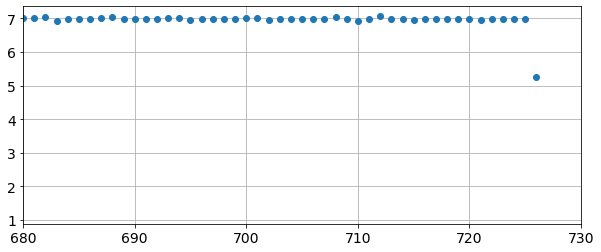

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(week,elapsed,'o');
ax.set(xlim=(680,730))
ax.grid();

In [ ]:
# export
def update_data(update_threshold=1, config=None):
    """Bring all of the local week data summaries up to date, downloading the missing ones from GSFC.
    If the last one is the current week, check to see if needs updating, by comparing file date, in days,
    from the last update with the current one at GSFC.
    """
    ff = FermiData(config)
    return ff.process(update_threshold)

In [ ]:
show_doc(update_data, title_level=2)

<h2 id="update_data" class="doc_header"><code>update_data</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h2>

> <code>update_data</code>(**`update_threshold`**=*`1`*, **`config`**=*`None`*)

Bring all of the local week data summaries up to date, downloading the missing ones from GSFC.
If the last one is the current week, check to see if needs updating, by comparing file date, in days,
from the last update with the current one at GSFC.

In [ ]:
#exporti
def get_week_files(config, week_range=None):
    """Return list of week files

    - week_range [None] -- tuple with inclusive range. If None, get all
    """
    import pandas as pd
    data_folder = config.datapath/'data_files'
    data_files = sorted(list(data_folder.glob('*.pkl')))
    weeks = week_range or  config.week_range
    if week_range is not None:

        slc = slice(*week_range) if type(week_range)==tuple else slice(week_range,week_range)
        wk_table = pd.Series(data=[df for df in data_files],
                     index= [ int(df.name[-7:-4]) for df in  data_files],
                    )
        data_files = wk_table.loc[slc].values

        if config.verbose>1:
            q = lambda x: x if x is not None else ""
            print(f'LoadData: Loading weeks[{q(slc.start)}:{q(slc.stop)}:{q(slc.step)}]', end='' if config.verbose<2 else '\n')
    else:
        if config.verbose>1: print(f'LoadData: loading all {len(data_files)} weekly files')

    if len(data_files)==0:
        msg =  f'Specified week_range {week_range} produced no output. Note that week numbers are 9-'
        raise Exception(msg)

    return data_files

In [ ]:
# export
def plot_week(week, nside=32, **kwargs):
    """
    Make an AIT plot of the given week's photon data
    
    Combine all energies for now
    
    - week -- the week number from 9
    - nside [32] -- HEALPix nside to project data before plotting.
    - kwargs -- args for healpix.ait_plot
    
    """
    import matplotlib.pyplot as plt
    from utilities import healpix as hpx
    
    assert nside & (nside-1) == 0, 'nside must be power of 2'
    config = Config()
    if not config.valid:
        print('No data to plot since config not valid', file=sys.stderr)
        return
    kw = dict(log=True, tick_labels=False, vmin=5, vmax=1e3,
             cblabel=f'counts per nside={nside} pixel')
    kw.update(kwargs)


    file = get_week_files(config,(week,week))[0]
    with open(file, 'rb') as inp:
        u = pickle.load(inp)
    ni = u['photons']['nest_index']
    utc = UTC(MJD((u['gti_times'][0])))[:-5]
    n = 12*nside**2
    # to convert data nside (1024 normally)
    shift = int(np.log2(config.nside/nside))
    pmap,_ = np.histogram( np.right_shift(ni,2*shift), np.linspace(0,n,n+1)) 
    t = hpx.HPmap(pmap, f'week_{week:d}\n{utc}', nest=True)
    t.ait_plot( **kw);

In [ ]:
show_doc(plot_week, title_level=2)

<h2 id="plot_week" class="doc_header"><code>plot_week</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h2>

> <code>plot_week</code>(**`week`**, **`nside`**=*`32`*, **\*\*`kwargs`**)

Make an AIT plot of the given week's photon data

Combine all energies for now

- week -- the week number from 9
- nside [32] -- HEALPix nside to project data before plotting.
- kwargs -- args for healpix.ait_plot

### Plot of a week's data

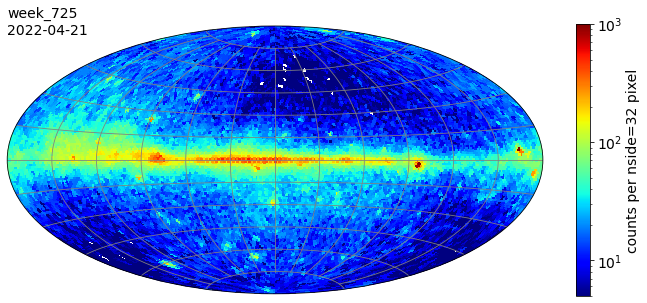

In [ ]:
plot_week(725)  

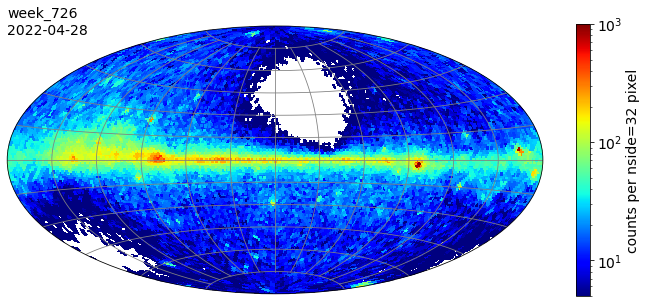

In [ ]:
plot_week(726)

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10-time_series.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_presentation.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Tue May  3 17:16:31 PDT 2022
